## Learning enzyme kinetics using NODEs

In [1]:
using OrdinaryDiffEq, Plots, Optim
using DiffEqFlux, Flux

## Functions

In [2]:
function prediction_vs_data(data, pred)
    C, time = data
    
    pl = plot_reaction(data)
    lcs = pl.series_list
    plot!(pl, time, pred[1,:], label = "", lc=lcs[1][:linecolor])
    plot!(pl, time, pred[2,:], label = "",  lc=lcs[2][:linecolor])
    plot!(pl, time, pred[3,:], label = "",  lc=lcs[3][:linecolor])
    return pl
end

prediction_vs_data (generic function with 1 method)

### The data

In [3]:
ν(G, L, Es, p) = p[1]*(G*L-Es/p[2])/(L + p[3]*G)

function rate(C)
    G, L, Es = C
    p = (9.03f-2, 5.0f-2, 1.9f1)
    ν(G, L, Es, p)
end

function reaction(du, u, p, t)
    G, L, Es = u
    dG  = du[1] = - ν(G, L, Es, p)
    dL  = du[2] = - ν(G, L, Es, p)
    dEs = du[3] =   ν(G, L, Es, p)
    return du
end

function reaction!(du, u, p, t)
    du = reaction(du, u, p, t)
end



function generate_true_solution(u₀, tₑ; nPoints=20)
    p = (9.03f-2, 5.0f-2, 1.9f1)
    tspan = (0.0, tₑ)
    prob = ODEProblem(reaction!, u₀, tspan, p, saveat=0:tₑ/nPoints:tₑ)
    sol = solve(prob, Tsit5())
    G = [c[1] for c in sol.u]
    L = [c[2] for c in sol.u]
    Es = [c[3] for c in sol.u]
    time = sol.t

  return permutedims([G L Es]), time
end

function plot_reaction(data)
  C, time = data
  pl = plot(xlabel="Time (min)", ylabel="Concentration (mM)", 
      ylims=(-2, 1.2*maximum(C)),
      xlims=(-2, time[end]*1.01))
  scatter!(pl, time, C[1,:], label="Glucose")
  scatter!(pl, time, C[2,:], label="Lauric acid")
  scatter!(pl, time, C[3,:], label="Gluc-Lau-Esther")
  return pl
end;

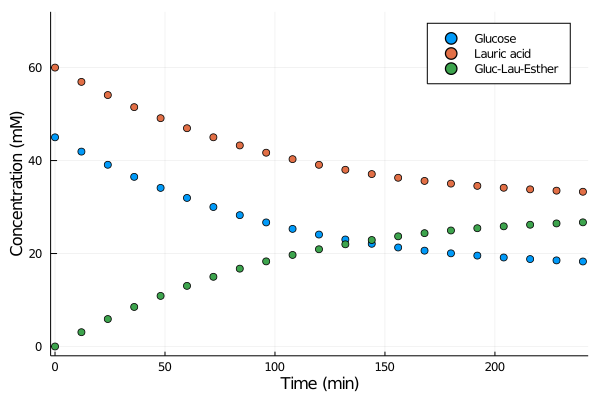

In [4]:
C₀ = Float32[45.0; 60.0; 0.0]
tₑ = 240.0f0
data = generate_true_solution(C₀, 240.0)
plot_reaction(data)

## Training on a single experiment

In [5]:
C, time = data
ann = Chain(Dense(3, 20, σ), Dense(20, 8, σ), Dense(8,1), x->x.*[1.0; 1.0; -1.0])
p, re = Flux.destructure(ann) # use this p as the initial condition!
dCdt(u,p,t) = re(p)(u) # need to restrcture for backprop!

prob = ODEProblem(dCdt, C₀, (0, tₑ))

function predict_neuralODE(C₀)
    Array(solve(prob,Tsit5(),u0=C₀,p=p,saveat=time))
end


predict_neuralODE (generic function with 1 method)

In [6]:
L₁() = sum((C.-predict_neuralODE(C₀)).^2);

In [7]:
cb = function (;doplot = true)
  # plot current prediction against data
    pred = predict_neuralODE(C₀)
    pl = prediction_vs_data(data, pred)

    if doplot
        IJulia.clear_output(true)
        display(plot(pl))
    end
    return false
end

#12 (generic function with 1 method)

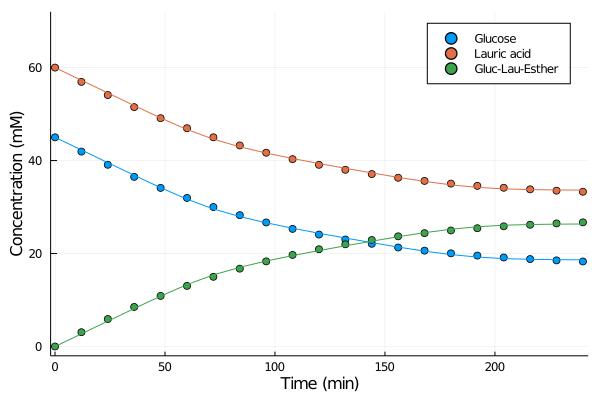

In [8]:
epochs = Iterators.repeated((), 200)
Flux.train!(L₁, Flux.params(p), epochs, ADAM(0.05), cb = cb)

### Testing

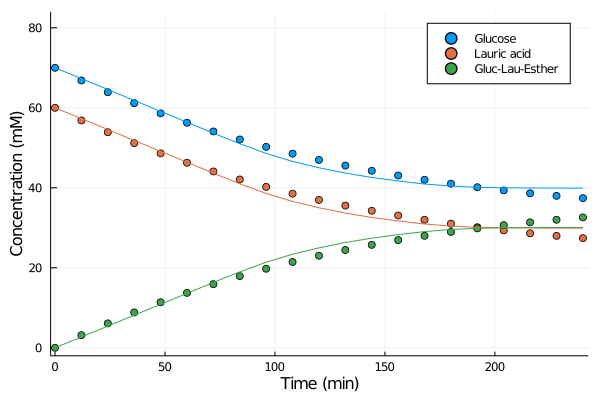

In [9]:
C₀ = Float32[70.0; 60.0; 0.0]
tₑ = 240.0f0
data = generate_true_solution(C₀, 240.0);
pred = predict_neuralODE(C₀)
pl = prediction_vs_data(data, pred)

## Adding more experiments

In [72]:
initialConditions = 
[
    Float32[30.0; 60.0; 0.0],
    Float32[45.0; 60.0; 0.0],
    Float32[60.0; 60.0; 0.0],
    Float32[30.0; 60.0; 15.0],
    Float32[45.0; 60.0; 15.0],
    Float32[60.0; 60.0; 15.0],
    Float32[30.0; 60.0; 30.0],
    Float32[45.0; 60.0; 30.0],
    Float32[60.0; 60.0; 30.0],
    Float32[15.0; 60.0; 0.0],
    Float32[15.0; 60.0; 15.0],
    Float32[15.0; 60.0; 30.0]
];

In [73]:
datasets = [generate_true_solution(C₀, 240.0) for C₀ in initialConditions];

In [74]:
function trainingLoss()
    loss = 0.0
        
    for (index, C₀) in enumerate(initialConditions)
        C, time = datasets[index]  
        pred = predict_neuralODE(C₀)
        loss += sum((C.-pred).^2);
    end
    return loss
end;

In [75]:
cb4 = function (;doplot = true)
  # plot current prediction against data
    
    l = @layout [a b; c d]
    pls = []
    for C₀ in initialConditions[1:4]
        data = generate_true_solution(C₀, 240.0);
        C, time = data  
        pred = predict_neuralODE(C₀)
        push!(pls, prediction_vs_data(data, pred))
    end
    
    if doplot
        IJulia.clear_output(true)
        pl = plot(pls[1], pls[2], pls[3], pls[4], layout = l, size=(900, 700))
        display(pl)
    end
    return false
end;

In [76]:
epochs = Iterators.repeated((), 700)
Flux.train!(trainingLoss, Flux.params(p), epochs, ADAM(0.05)) 

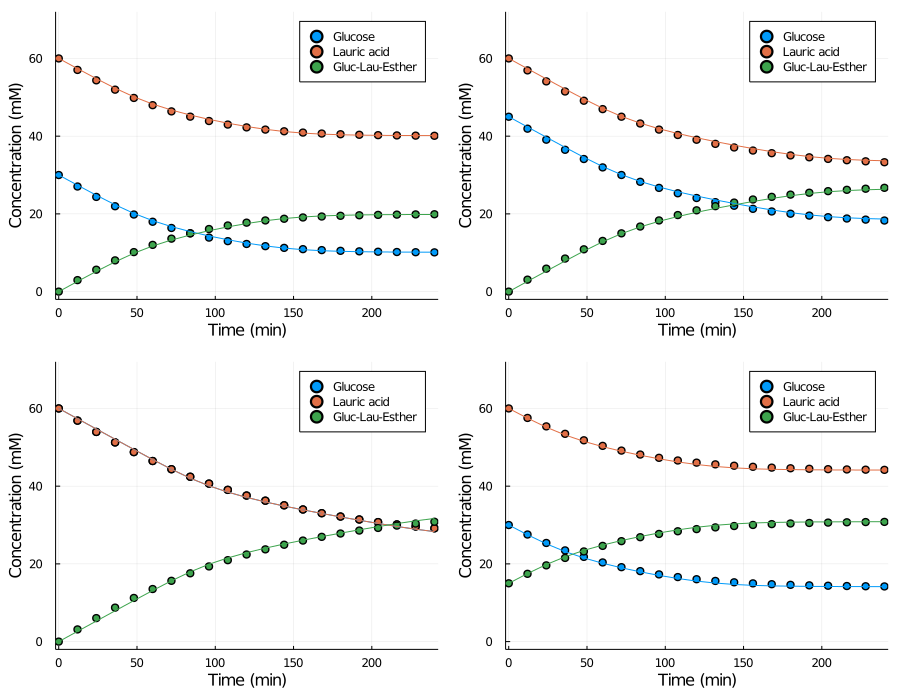

false

In [77]:
cb4()

## How well did we learn the true kinetics? 

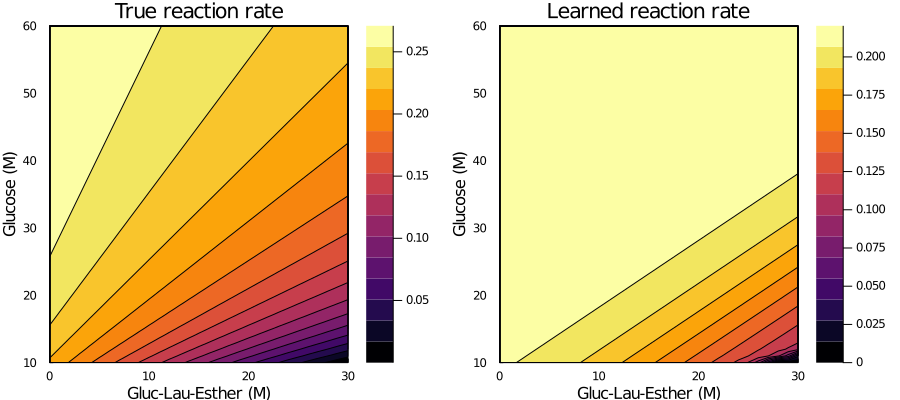

In [91]:
G = 10:1.0:60
L = 60.0
Es = 0.0:1.0:30.0

X = Iterators.product(G, L, Es)
l = @layout [a b]
c₁ = contourf(Es, G, rate.(X), 
        xlabel = "Gluc-Lau-Esther (M)", 
        ylabel="Glucose (M)", 
        title="True reaction rate")

R = [dCdt([C[1]; C[2]; C[3]], p, 0.0)[3] for C in X]
c₂ = contourf(Es, G, min.(max.(R, 0.0),maximum(R)), 
        xlabel = "Gluc-Lau-Esther (M)", 
        ylabel="Glucose (M)", 
        title="Learned reaction rate")

G = [C[1] for C in initialConditions]
Es = [C[3] for C in initialConditions]

#scatter!(Es, G, grid=false, label="")

plot(c₁, c₂, layout=l, size=(900, 400))